# Using neural_network with circular data

In this notebook, we use the `neural_network` package to predict whether datapoints lie inside or outside the unit disc in the $x-y$ plane. Note that this notebook follows the same example as within the `examples/classification/circle` directory if you prefer not to use Jupyter notebook. Here we assume that `neural_network` is pip installed onto your machine. If you have not done so, please see `README.md` in the python package for installation instructions.

In [1]:
import matplotlib.pyplot as plt

Below, we ensure that the `Plotter` class will show all the plots for this notebook.

In [2]:
from neural_network import Plotter
Plotter.show_plots = True

## Generating our data

The first step is to generate some labelled data, with points inside the unit disc belonging to one class, and points outside belonging to another. This will be our ground truth data, and we can use a `UniformDataGenerator` to generate some uniformly distributed data.

In [3]:
from neural_network import UniformDataGenerator

`UniformDataGenerator` takes the following arguments to its constructor method:

| argument         | type          | description|
|------------------|---------------|---------------|
| `function`       | `Callable`    | This `function` takes in the coordinates of the datapoint as arguments, and returns either a discrete class or value for classification and regression problems respectively.|
| `num_datapoints` | `int`         | The number of datapoints to be generated.|
| `lower_bounds`          | `List[float]` | The lower bound of each coordinate.|
| `upper_bounds`       | `List[float]` | The upper bound of each coordinate.|

For our example, the `function` will take `x_1` and `x_2` as arguments and return a string for whether the point is `"Inside"` or `"Outside"` the unit disc.

In [4]:
def classifier(x_1: float, x_2: float) -> str:

    if x_1**2 + x_2**2 < 1:
        return "Inside"
    else:
        return "Outside"

Now we can generate a number of datapoints, and create a scatter plot using `generator.plot_datapoints`.

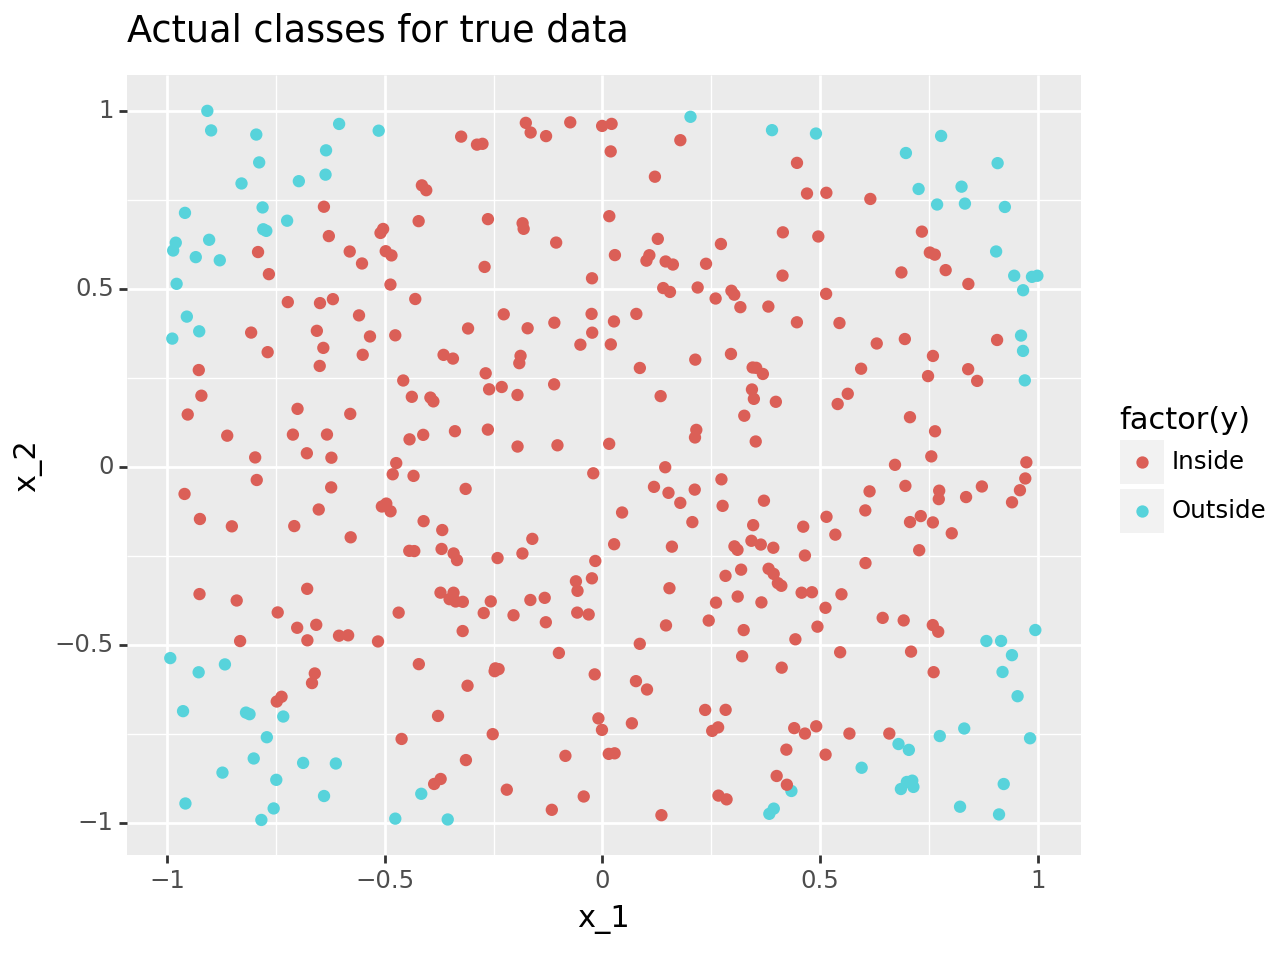

C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: true_scatter_circle.png


In [5]:
generator = UniformDataGenerator(classifier, num_datapoints=400, lower_bounds=[-1.0, -1.0], upper_bounds=[1.0, 1.0])
df = generator()
generator.plot_datapoints(title="circle")

We can then save this dataframe to a .csv file to store it.

In [6]:
generator.write_to_csv(title="circle_data")

## Splitting data and constructing the network

Now that we have some data to work with, we can begin learning! Our goal is to train a neural network to learn the patterns of the data and be able to accurately predict whether a point lies inside or outside the unit disc. In order to do this, we will need to split our data into a training set, validation set and testing set. Below is a brief description of what is involved in each phase.

|phase|description|common percentage of total data|
|---|-------|---|
|training|We train our network on the majority of the data. For this phase, we send our data through the network to generate a prediction of the class, and then update the network's weights and biases depending on how good the prediction is (back propagation). We iterate this process over a number of epochs.|80%|
|validation|During training, we pass our validation set through the network WITHOUT doing back propagation to see how well the network performs on unseen data at each epoch.|10%|
|testing|Finally, after we have run all epochs of training and validation, we test our remaining data on the network to see how well the network performs after training has finished. We use this testing data to generate metrics of how well the network has performed.|10%|

We can make use of a helper class to randomly split our data up.

In [7]:
from neural_network import DataSplitter
data_splitter = DataSplitter(path="circle_data.csv", proportions=[8, 1, 1])
training_data, validation_data, testing_data = data_splitter.split()

Our next step is to construct the `network` itself. Below is a list of parameters that can be passed to the `Network` constructor. 

| parameter           | type        | description                                                                                               | default  |
|---------------------|-------------|-----------------------------------------------------------------------------------------------------------|----------|
| `num_features`      | `int`       | The number of features (x coordinates) per datapoint.                                                     | ---      |
| `num_hidden_layers` | `int`       | The number of hidden layers of the network.                                                               | ---      |
| `neuron_counts`     | `List[int]` | The number of neurons in each hidden layer.                                                               | ---      |
| `num_classes`       | `int`       | The number of classes in the data for a classification problem. This parameter is ignored for regression. | `2`      |
| `regression`        | `bool`      | `True` corresponds to regression, `False` is classification.                                              | `False`  |
| `leak`              | `float`     | The leak for the ReLU function. Choose `0` for no leak.                                                   | `0.01`   |
| `learning_rate`     | `float`     | The learning rate for the network.                                                                        | `0.01`   |
| `adaptive`          | `bool`      | Whether we wish to have an adaptive learning rate or not (using momentum).                                | `False`  |
| `gamma`             | `float`     | The adaptive learning rate parameter. This is ignored if `adaptive` is `False`                            | `0.9`    |
| `he_weights`        | `bool`      | Whether we wish to initialise the weights of the network according to He or not [$^{[1]}$](Sources).                     | `False`  |

For the circle data, we have 2 features (x_1, x_2) and 2 classes (inside, outside), but we are free to specify the rest. We will
mostly use defaults, but have some of the booleans turned on.

In [8]:
from neural_network import Network
network = Network(num_features=2, num_hidden_layers=3, neuron_counts=[4, 4, 4],
                  adaptive=True, he_weights=True)


We can use `network.visualise_network` (which uses the `networkx` package) to visualise the network.

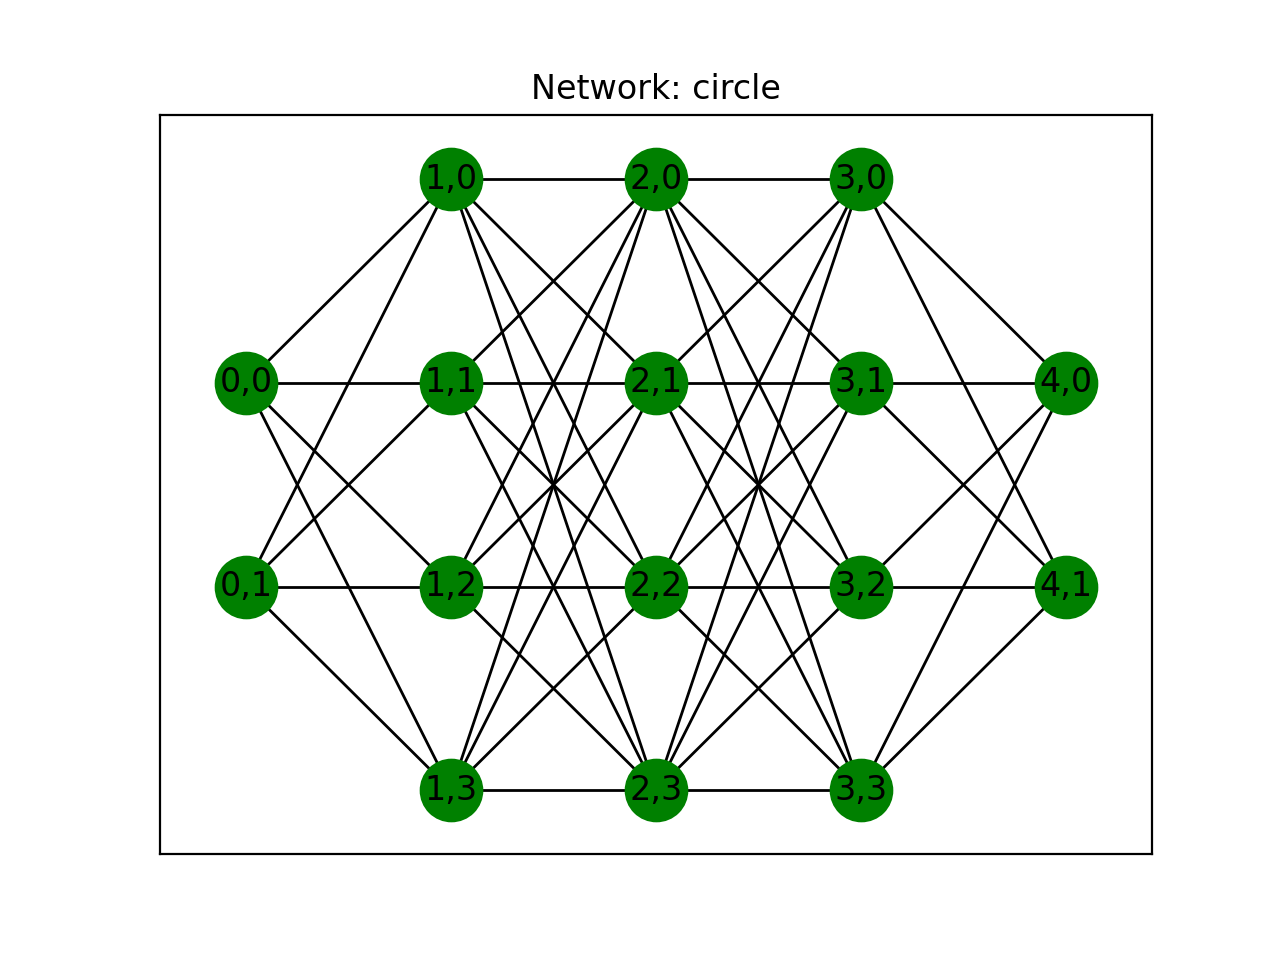

In [9]:
network.visualise_network("circle")

We can see the input layer, three hidden layers and an output layer for this network.

## Learning

Now we are ready to start using the learners - `Trainer`, `Validator` and `Tester`. We can pass the following parameters to the learner's constructors:

| parameter    | type           | description                                           | default |
|--------------|----------------|-------------------------------------------------------|---------|
| `network`    | `Network`      | Our network from above.                               | ---     |
| `data`       | `pd.DataFrame` | The data for the specific phase.                      | ---     |
| `batch_size` | `int`          | The batch size we wish to use.                        | ---     |
| `weighted`   | `bool`         | Whether we want weighted or unweighted batches.       | `False` |
| `validator`  | `Validator`    | **TRAINER ONLY** - the already instantiated validator.| `None`  |
| `num_epochs` | `int`          | **TRAINER ONLY** - the number of epochs to train for. | ---     |

During each epoch, we will send the data through in batches of a fixed `batch_size`, and then back-propagate through the network after each batch. For unweighted batches, we simply randomly partition the dataset into batches and the network will see all the data each epoch. For weighted batches, instead we give each class a weight depending on how many elements there are and then use the inverse of these weights as proportions for choosing in
the batches.

This way, for classes of quite different sizes, we over-sample from smaller classes and under-sample from larger classes to give the network
a better chance of learning the patterns in the data. For our example, there are many more points **inside** the circle than **outside**, so
points on the **outside** have a greater chance of being picked for the batch when we choose to set `weighted=True`.

In [10]:
from neural_network import Validator, Trainer, Tester
validator = Validator(network, validation_data, batch_size=10)
trainer = Trainer(network, training_data, num_epochs=1000, batch_size=16,
                  weighted=True, validator=validator)
tester = Tester(network, testing_data, batch_size=10)

We can now run the `trainer`! Note this also runs the `validator`, and we will get updates on training and validation loss throughout.

In [11]:
trainer.run()

Epoch: 0
Loss: 0.80906824
Validation loss: 0.70320816
Epoch: 10
Loss: 0.68837819
Validation loss: 0.69171413
Epoch: 20
Loss: 0.66895563
Validation loss: 0.64195028
Epoch: 30
Loss: 0.66218142
Validation loss: 0.63822707
Epoch: 40
Loss: 0.64704191
Validation loss: 0.63393969
Epoch: 50
Loss: 0.66218578
Validation loss: 0.61934512
Epoch: 60
Loss: 0.65854661
Validation loss: 0.58468741
Epoch: 70
Loss: 0.51984935
Validation loss: 0.44223364
Epoch: 80
Loss: 0.35497204
Validation loss: 0.37011128
Epoch: 90
Loss: 0.27832861
Validation loss: 0.23939535
Epoch: 100
Loss: 0.25060684
Validation loss: 0.22912798
Epoch: 110
Loss: 0.21668163
Validation loss: 0.13465398
Epoch: 120
Loss: 0.16518114
Validation loss: 0.16312421
Epoch: 130
Loss: 0.17546384
Validation loss: 0.14335962
Epoch: 140
Loss: 0.16909658
Validation loss: 0.0979255
Epoch: 150
Loss: 0.20409246
Validation loss: 0.1831198
Epoch: 160
Loss: 0.13414059
Validation loss: 0.11840437
Epoch: 170
Loss: 0.1682172
Validation loss: 0.14622383
Epoch:

We lastly run the `tester` to see how well the network does on unseen data.

In [12]:
tester.run()

Testing loss: 0.33206145


## Plotting the results

There are a few different evaluation plots we can use to see how well the network has performed. Firstly, we can plot the loss over
time for training and validation:

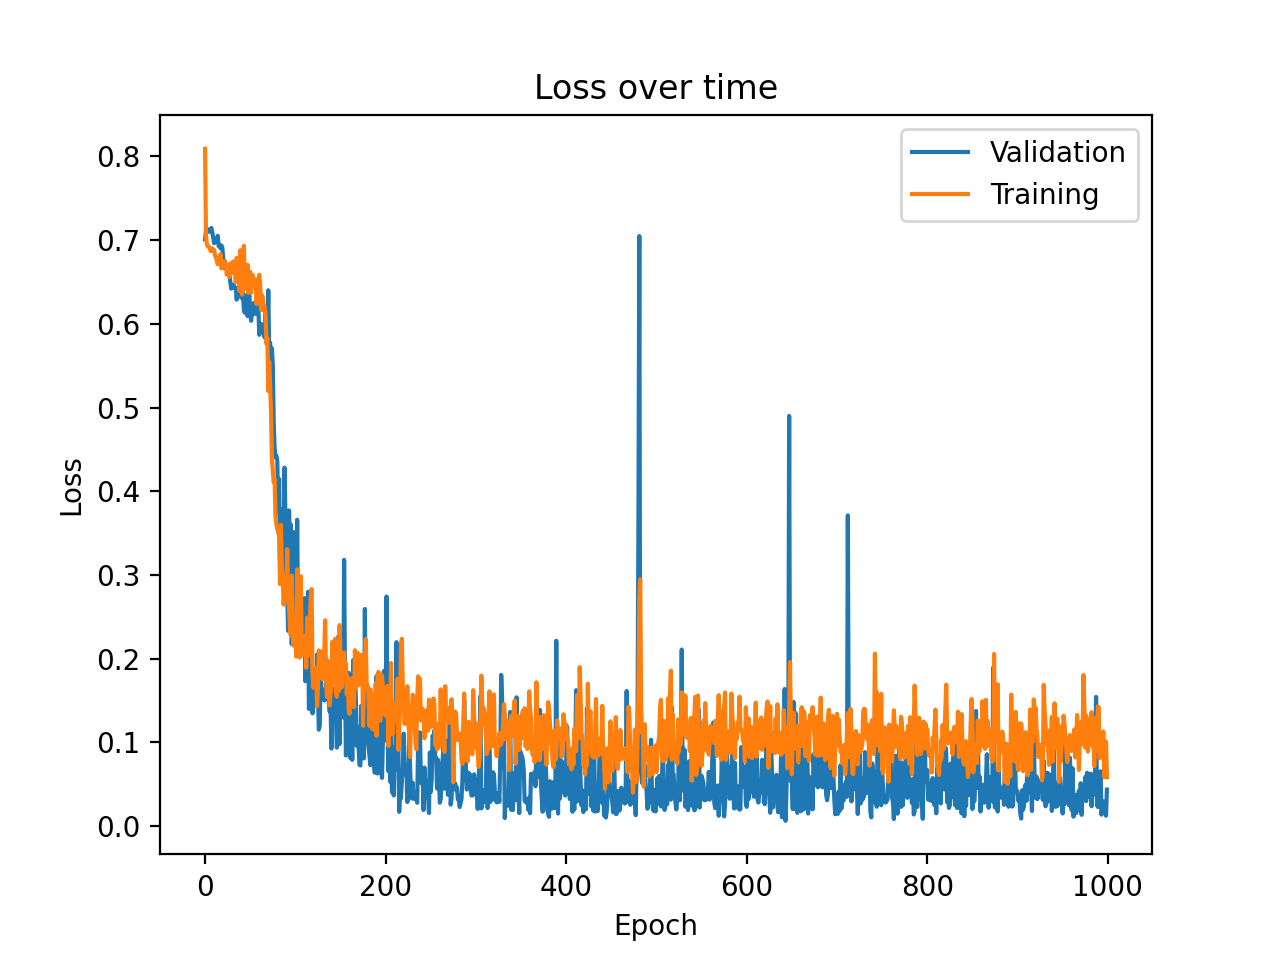

In [13]:
trainer.generate_loss_plot(title='circle')

Next, we can see some scatter plots for the predicted classes:

<Figure size 640x480 with 0 Axes>

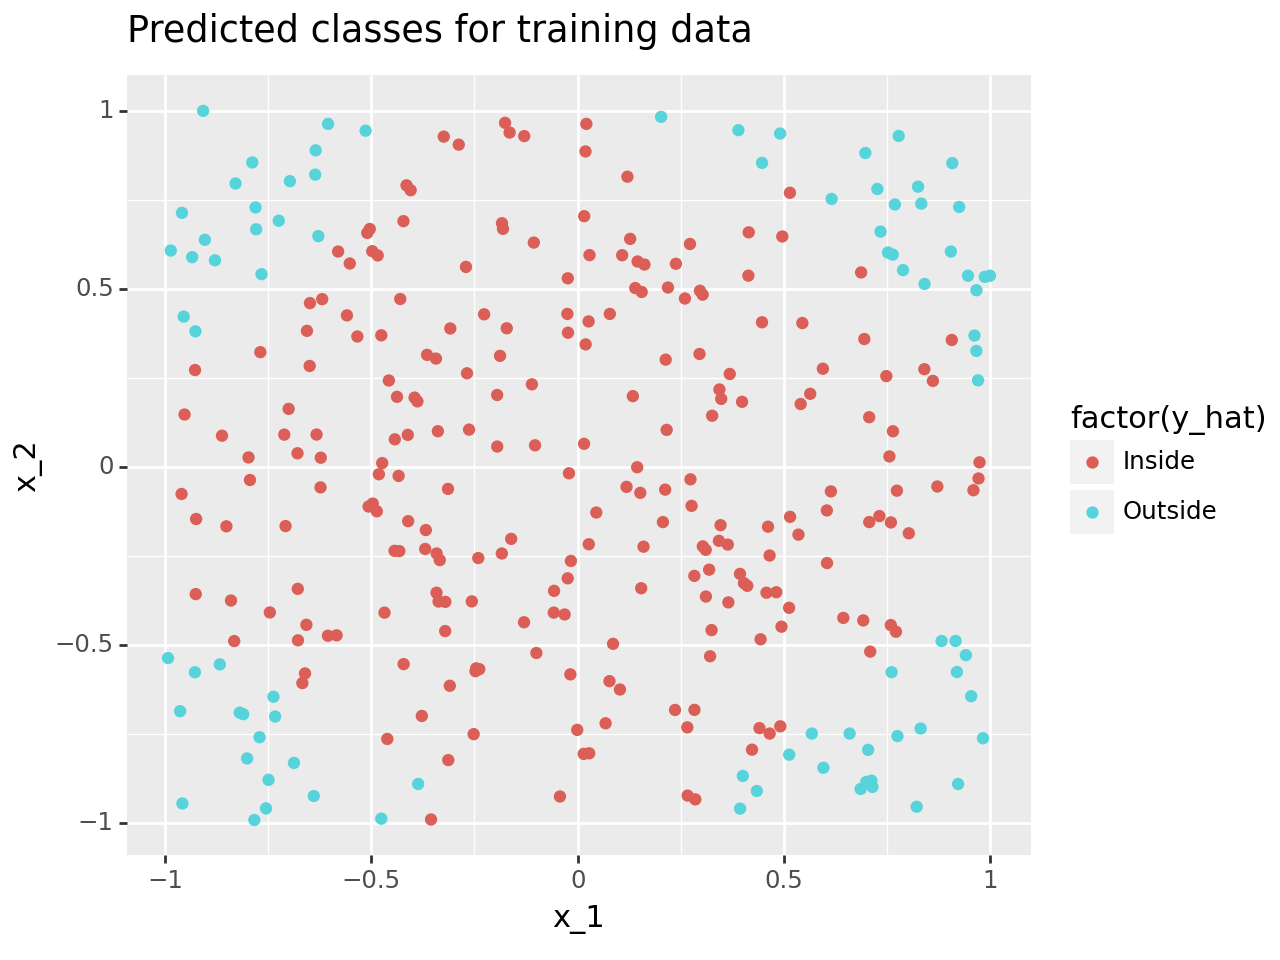

C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: plots/training/scatter_circle.png


In [14]:
trainer.generate_scatter(title='circle')

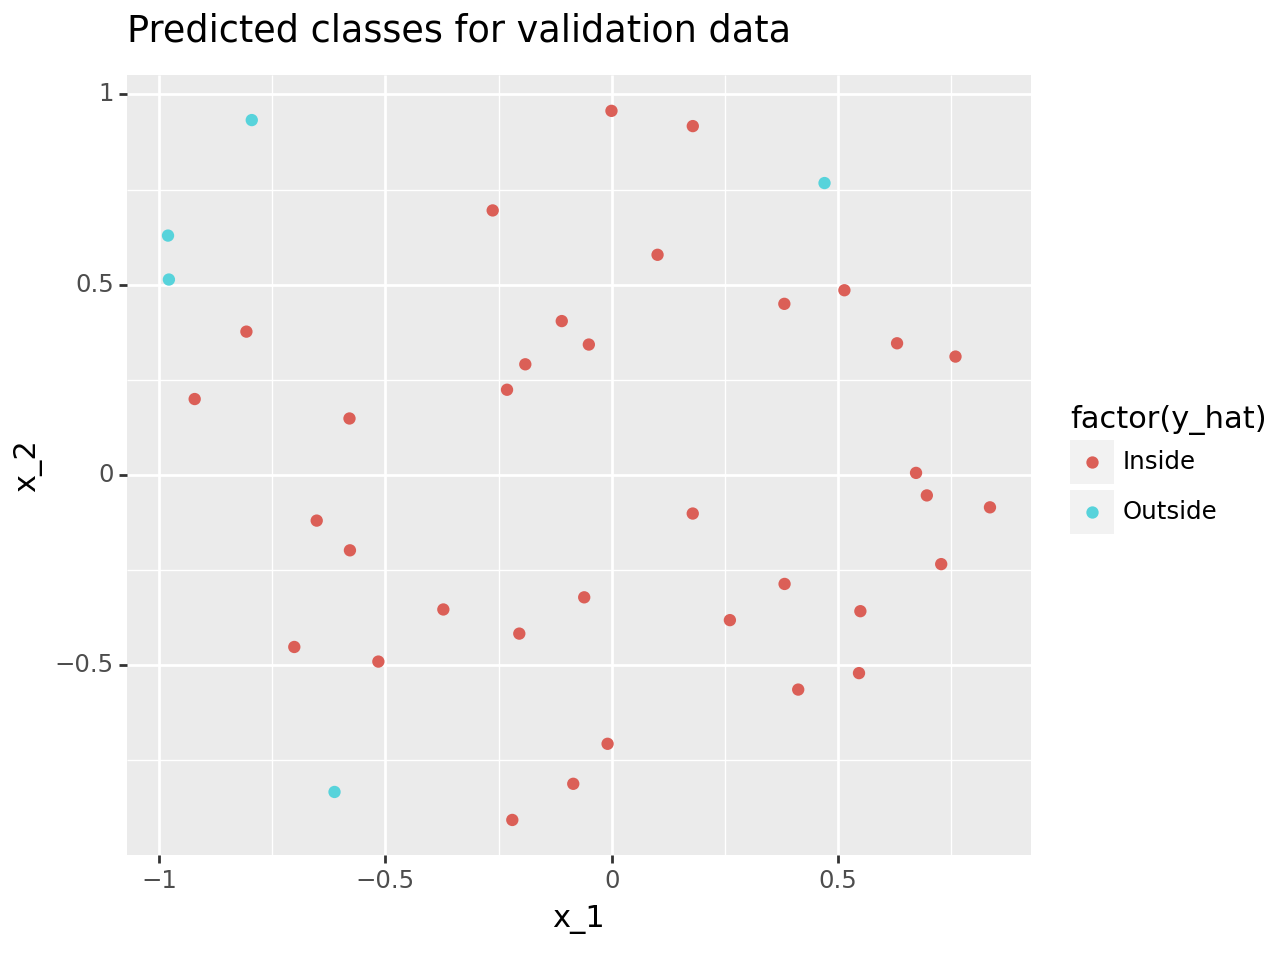

C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: plots/validation/scatter_circle.png


In [15]:
validator.generate_scatter(title='circle')

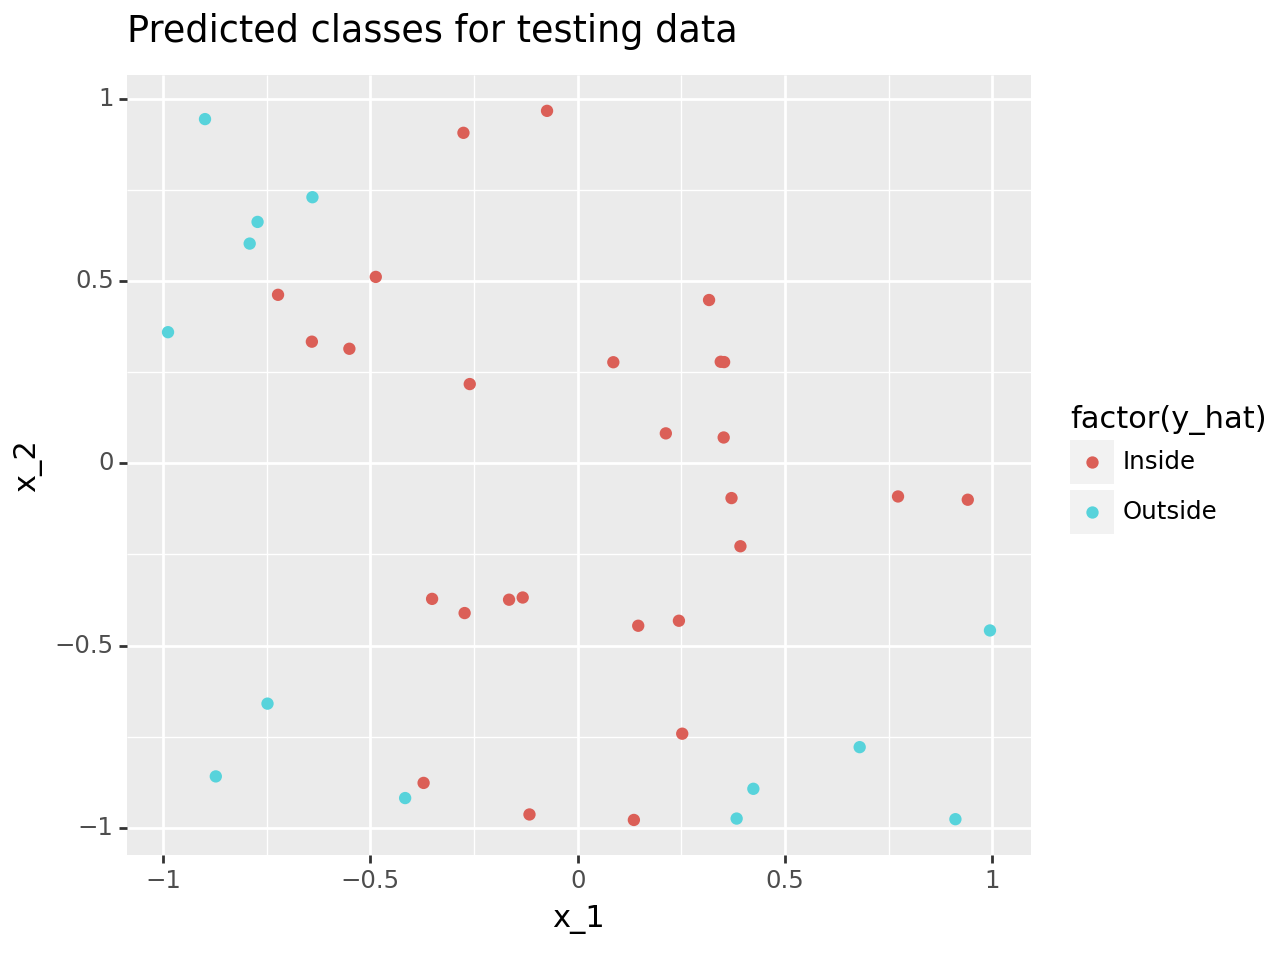

C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: plots/testing/scatter_circle.png


In [16]:
tester.generate_scatter(title='circle')

Finally, we can print out the confusion matrix and dice scores for the testing data.

In [17]:
tester.generate_confusion()

Confusion matrix for testing data:
y_hat    Inside  Outside
y                       
Inside       27        4
Outside       0        9
Dice scores: {'Inside': 0.9310344827586207, 'Outside': 0.8181818181818182}
Mean dice score: 0.8746081504702194


## Sources

$^{[1]}$: K. He et al., [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://openaccess.thecvf.com/content_iccv_2015/html/He_Delving_Deep_into_ICCV_2015_paper.html), Proceedings of the IEEE International Conference on Computer Vision (ICCV), 2015, pp. 1026-1034